<a href="https://colab.research.google.com/github/Hamza-Ali0237/PyTorch-Projects/blob/main/Intermediate/PyTorch-TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog vs. Cat Classifier with Transfer Learning

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

# Download Dataset

In [2]:
# --- Configuration and Setup ---
import os

# Ensure Kaggle is configured for dataset download
# Upload kaggle.json to colab's /content/ directory
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
os.system('cp /content/kaggle.json ~/.kaggle/')
os.system('chmod 600 ~/.kaggle/kaggle.json')

# Download and extract the dogs vs cats dataset
# This part assumes the dataset isn't already extracted.
# If it is, then comment out or skip these lines.
os.system('kaggle datasets download -d salader/dogs-vs-cats')
os.system('unzip -q dogs-vs-cats.zip -d dogs_vs_cats_data')

0

# Import Libraries

In [7]:
import torch
import torch.nn as torch
import torchvision as tv
import torchmetrics as tm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Dataset Class

In [5]:
class DogsCatsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        for phase in ['train', 'test']:
            phase_path = os.path.join(root_dir, phase)
            if os.path.isdir(phase_path):
                for class_name in ['dogs', 'cats']:
                    class_path = os.path.join(phase_path, class_name)
                    if os.path.isdir(class_path):
                        for image_file in os.listdir(class_path):
                            self.image_files.append(os.path.join(class_path, image_file))
                            self.labels.append(0 if class_name == 'cats' else 1)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load Dataset

Label: Dog


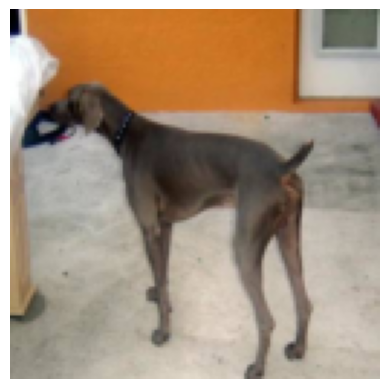

In [8]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load Dataset
dataset = DogsCatsDataset("/content/dogs_vs_cats_data", transform)

# Display Image
img, label = dataset[0]
print(f"Label: {'Cat' if label == 0 else 'Dog'}")
plt.imshow(np.transpose(img.numpy(), (1,2,0)))
plt.axis("off")
plt.show()